# Figure 3: Thalamus subregions

And related supplementary figures.


In [13]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.gridspec as gridspec
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import local_env
import VideoAnalysisUtils.functions as func
import VideoAnalysisUtils.plotting_utils as plt_utils
import VideoAnalysisUtils.plot_style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data and stuff

In [2]:
figfolder = '../figs/manuscript_drafts/'
os.makedirs(figfolder, exist_ok=True)

In [3]:
class Annotation_from_Coords():
    def __init__(self, datafolder = '../data/', tif_name = 'Annotation_new_10_ds222_32bit.tif', csv_name = 'mousebrainontology_2.csv'):
        self.image_data = self.load_tif_fast(datafolder + tif_name)
        self.df = pd.read_csv(datafolder + csv_name, header = None,names = ['annotation_index', 'annotation'])

    def load_tif_fast(self, file_tif):
        from PIL import Image
        print(f'Loading {file_tif}...')
        # Open the TIF file
        with Image.open(file_tif) as img:
            # Extract image dimensions and frames
            xpix, ypix = img.size
            frames = img.n_frames
            
            # Determine bit depth and data type
            mode_to_bitdepth = {
                'L': 8,    # 8-bit pixels, grayscale
                'P': 8,    # 8-bit pixels, mapped to any other mode using a color palette
                'I;16': 16, # 16-bit pixels, grayscale
                'I;16B': 16, # 16-bit pixels, big endian
                'I': 32,   # 32-bit signed integer pixels
                'F': 32    # 32-bit floating point pixels
            }
            
            bitdepth = mode_to_bitdepth.get(img.mode, None)
            if bitdepth == 32:
                dtype = np.uint32
            elif bitdepth == 16:
                dtype = np.uint16
            elif bitdepth == 8:
                dtype = np.uint8
            else:
                raise ValueError("Unsupported bit depth")
            
            # Initialize empty array to hold image data
            im = np.zeros((ypix, xpix, frames), dtype=dtype)
            
            for i in range(frames):
                img.seek(i)  # Move to the specified frame
                im[:, :, i] = np.array(img)
        
        print('Done loading Tif')
        return im
    
    def get_annotation(self, ccf_ml, ccf_dv, ccf_ap, reso = 20):
        ccf_ml_voxel = int(ccf_ml / reso)
        ccf_dv_voxel = int(ccf_dv / reso)
        ccf_ap_voxel = int(ccf_ap / reso)
        annotation_index = self.image_data[ccf_ml_voxel, ccf_dv_voxel, ccf_ap_voxel]
        if annotation_index == 0:
            return 'Outside CCF'
        if annotation_index in self.df['annotation_index'].values:
            annotation = self.df.loc[self.df['annotation_index'] == annotation_index, 'annotation'].values[0]
        else:
            annotation = 'No annotation'
        return annotation
    
annot = Annotation_from_Coords()
reso = 20
#image dims: ML,DV,AP
size = np.array([reso * s for s in annot.image_data.shape])
print(size)

#plt.imshow(annot.image_data[:,300,:].T, origin = 'lower', cmap = 'Greys',extent = [0,size[1],0,size[2]], vmax = 1000)

image_plot_DV_start = 100
image_plot_DV_length = 200
image_plot_ML_mid = 285
image_plot_ML_half_length = 150
image_plot_AP_group1 = 340
image_plot_AP_group2 = 330


Loading ../data/Annotation_new_10_ds222_32bit.tif...
Done loading Tif
[ 8000 11400 13200]


In [4]:
tif_name = 'AllenRefVolCoronal_10_ds222.tif'
from PIL import Image

res_image = 20 # image resolution
im = Image.open('../data/%s'%tif_name)
h, w = np.shape(im)
n_frames = im.n_frames
im_array = np.zeros((h,w,n_frames)) # (400, 570, 660), (DV, ML, AP)
for i in range(im.n_frames):
    im.seek(i)
    im_array[:,:,i] = np.array(im)
print('Anatomy data loaded.')

Anatomy data loaded.


## Main figure

In [5]:
fig4 = plt_utils.Figure4()
fig4.load_data()

/home/kurgyis/.local/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/kurgyis/.local/lib/python3.8/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/kurgyis/.local/lib/python3.8/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


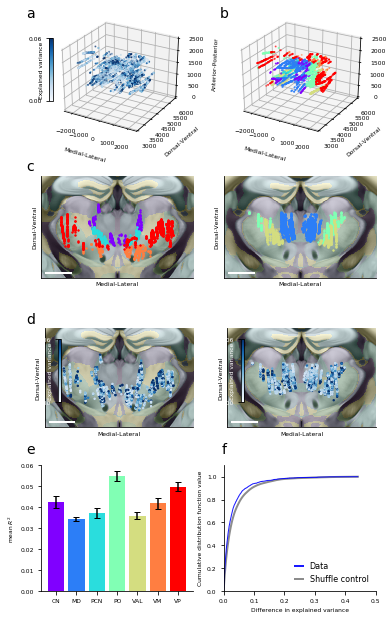

<Figure size 432x764.64 with 0 Axes>

In [6]:
plt.rcParams['figure.figsize'][1] = style.fig_w_max * 18 / 12

fig = plt.figure()

#fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(4,2,1, projection='3d')
ax2 = fig.add_subplot(4,2,2, projection='3d')

ax3 = fig.add_subplot(4,2,3)
ax4 = fig.add_subplot(4,2,4)
ax5 = fig.add_subplot(4,2,5)
ax6 = fig.add_subplot(4,2,6)
ax7 = fig.add_subplot(4,2,7)
ax8 = fig.add_subplot(4,2,8)

sc1 = fig4.add_colorbar_scatter_plot(ax1, group_list = fig4.short_names_correct_allen, three_d_flag = True,)
divider = make_axes_locatable(ax1)
# Append axes to the left of ax, with 5% width of ax
cax = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax.set_axis_off()
cax.patch.set_facecolor('none')

# Create the colorbar in the new axes
cbar1 = fig.colorbar(sc1, ax=cax, )
cbar1.ax.set_position([cbar1.ax.get_position().x0 - 0.28,  # Move left
                      cbar1.ax.get_position().y0 + 0.05,  # Move down
                      cbar1.ax.get_position().width, 
                      cbar1.ax.get_position().height/2])
cbar1.ax.yaxis.set_ticks_position('left')
cbar1.ax.yaxis.set_label_position('left')
cbar1.set_ticks([0, 0.06])
cbar1.set_label('Explained variance', labelpad = -15)

sc2 = fig4.add_solid_color_plot(ax2, group_list = fig4.short_names_correct_allen, three_d_flag = True,)

ax3.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax3.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc3 = fig4.add_solid_color_plot(ax3, group_list = fig4.group1_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))

ax4.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax4.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc4 = fig4.add_solid_color_plot(ax4, group_list = fig4.group2_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))

ax5.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax5.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc5 = fig4.add_colorbar_scatter_plot(ax5, group_list = fig4.group1_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))
divider = make_axes_locatable(ax5)
# Append axes to the left of ax, with 5% width of ax
cax5 = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax5.set_axis_off()
# Create the colorbar in the new axes
cbar5 = fig.colorbar(sc5, ax=cax5, )
cbar5.ax.set_position([cbar5.ax.get_position().x0 - 0.26,  # Move left
                      cbar5.ax.get_position().y0 + 0.05,  # Move down
                      cbar5.ax.get_position().width, 
                      cbar5.ax.get_position().height/2])
cbar5.ax.yaxis.set_ticks_position('left')
cbar5.ax.yaxis.set_label_position('left')
cbar5.set_ticks([0, 0.06])
cbar5.set_label('Explained variance', labelpad = -15)
cbar5.ax.yaxis.set_ticklabels(cbar5.ax.get_yticklabels(), color='white')
cbar5.ax.yaxis.label.set_color('white')

ax6.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax6.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc6 = fig4.add_colorbar_scatter_plot(ax6, group_list = fig4.group2_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))
divider = make_axes_locatable(ax6)
# Append axes to the left of ax, with 5% width of ax
cax6 = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax6.set_axis_off()
# Create the colorbar in the new axes
cbar6 = fig.colorbar(sc6, ax=cax6, )
cbar6.ax.set_position([cbar6.ax.get_position().x0 - 0.26,  # Move left
                      cbar6.ax.get_position().y0 + 0.05,  # Move down
                      cbar6.ax.get_position().width, 
                      cbar6.ax.get_position().height/2])
cbar6.ax.yaxis.set_ticks_position('left')
cbar6.ax.yaxis.set_label_position('left')
cbar6.set_ticks([0, 0.06])
cbar6.set_label('Explained variance', labelpad = -15)
cbar6.ax.yaxis.set_ticklabels(cbar6.ax.get_yticklabels(), color='white')
cbar6.ax.yaxis.label.set_color('white')

ax3.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax4.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax5.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax6.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)

fig4.plot_barplot_with_sem(ax7)
fig4.plot_r2_diff_nn_shuffle_cdf(ax8)

fig.text(0.1,  0.88, 'a', ha='center', va='center', fontsize=14)
fig.text(0.55, 0.88, 'b', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.68, 'c', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.48, 'd', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.31, 'e', ha='center', va='center', fontsize=14)
fig.text(0.55, 0.31, 'f', ha='center', va='center', fontsize=14)

#plt.savefig(figfolder + 'figure4_draft_v2.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

### CUrrent final version

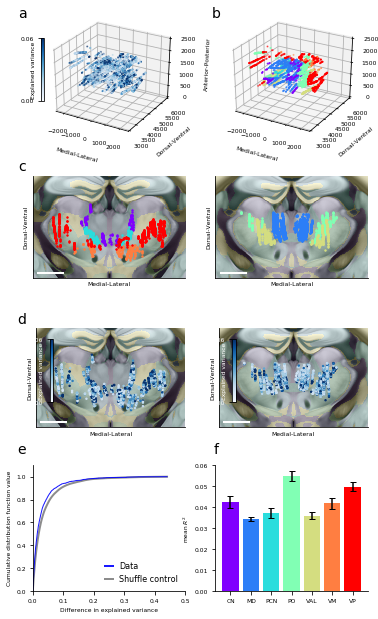

<Figure size 432x764.64 with 0 Axes>

In [7]:
plt.rcParams['figure.figsize'][1] = style.fig_w_max * 18 / 12

fig = plt.figure()

#fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(4,2,1, projection='3d')
ax2 = fig.add_subplot(4,2,2, projection='3d')

ax3 = fig.add_subplot(4,2,3)
ax4 = fig.add_subplot(4,2,4)
ax5 = fig.add_subplot(4,2,5)
ax6 = fig.add_subplot(4,2,6)
ax7 = fig.add_subplot(4,2,7)
ax8 = fig.add_subplot(4,2,8)

sc1 = fig4.add_colorbar_scatter_plot(ax1, group_list = fig4.short_names_correct_allen, three_d_flag = True,)
divider = make_axes_locatable(ax1)
# Append axes to the left of ax, with 5% width of ax
cax = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax.set_axis_off()
cax.patch.set_facecolor('none')

# Create the colorbar in the new axes
cbar1 = fig.colorbar(sc1, ax=cax, )
cbar1.ax.set_position([cbar1.ax.get_position().x0 - 0.28,  # Move left
                      cbar1.ax.get_position().y0 + 0.05,  # Move down
                      cbar1.ax.get_position().width, 
                      cbar1.ax.get_position().height/2])
cbar1.ax.yaxis.set_ticks_position('left')
cbar1.ax.yaxis.set_label_position('left')
cbar1.set_ticks([0, 0.06])
cbar1.set_label('Explained variance', labelpad = -15)

sc2 = fig4.add_solid_color_plot(ax2, group_list = fig4.short_names_correct_allen, three_d_flag = True,)

ax3.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax3.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc3 = fig4.add_solid_color_plot(ax3, group_list = fig4.group1_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))

ax4.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax4.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc4 = fig4.add_solid_color_plot(ax4, group_list = fig4.group2_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))

ax5.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax5.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc5 = fig4.add_colorbar_scatter_plot(ax5, group_list = fig4.group1_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))
divider = make_axes_locatable(ax5)
# Append axes to the left of ax, with 5% width of ax
cax5 = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax5.set_axis_off()
# Create the colorbar in the new axes
cbar5 = fig.colorbar(sc5, ax=cax5, )
cbar5.ax.set_position([cbar5.ax.get_position().x0 - 0.26,  # Move left
                      cbar5.ax.get_position().y0 + 0.05,  # Move down
                      cbar5.ax.get_position().width, 
                      cbar5.ax.get_position().height/2])
cbar5.ax.yaxis.set_ticks_position('left')
cbar5.ax.yaxis.set_label_position('left')
cbar5.set_ticks([0, 0.06])
cbar5.set_label('Explained variance', labelpad = -15)
cbar5.ax.yaxis.set_ticklabels(cbar5.ax.get_yticklabels(), color='white')
cbar5.ax.yaxis.label.set_color('white')

ax6.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax6.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc6 = fig4.add_colorbar_scatter_plot(ax6, group_list = fig4.group2_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))
divider = make_axes_locatable(ax6)
# Append axes to the left of ax, with 5% width of ax
cax6 = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax6.set_axis_off()
# Create the colorbar in the new axes
cbar6 = fig.colorbar(sc6, ax=cax6, )
cbar6.ax.set_position([cbar6.ax.get_position().x0 - 0.26,  # Move left
                      cbar6.ax.get_position().y0 + 0.05,  # Move down
                      cbar6.ax.get_position().width, 
                      cbar6.ax.get_position().height/2])
cbar6.ax.yaxis.set_ticks_position('left')
cbar6.ax.yaxis.set_label_position('left')
cbar6.set_ticks([0, 0.06])
cbar6.set_label('Explained variance', labelpad = -15)
cbar6.ax.yaxis.set_ticklabels(cbar6.ax.get_yticklabels(), color='white')
cbar6.ax.yaxis.label.set_color('white')

ax3.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax4.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax5.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax6.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)

fig4.plot_barplot_with_sem(ax8)
fig4.plot_r2_diff_nn_shuffle_cdf(ax7)

fig.text(0.1,  0.88, 'a', ha='center', va='center', fontsize=14)
fig.text(0.55, 0.88, 'b', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.68, 'c', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.48, 'd', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.31, 'e', ha='center', va='center', fontsize=14)
fig.text(0.55, 0.31, 'f', ha='center', va='center', fontsize=14)

#plt.savefig(figfolder + 'figure4_draft_v3.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

### Karel's suggestion
Not in use.

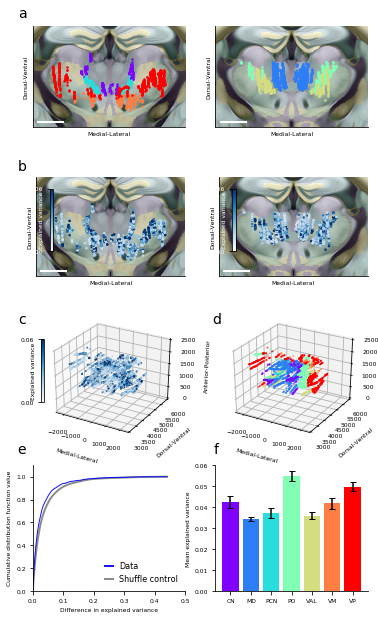

<Figure size 432x764.64 with 0 Axes>

In [8]:
plt.rcParams['figure.figsize'][1] = style.fig_w_max * 18 / 12

fig = plt.figure()

#fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(4,2,5, projection='3d')
ax2 = fig.add_subplot(4,2,6, projection='3d')

ax3 = fig.add_subplot(4,2,1)
ax4 = fig.add_subplot(4,2,2)
ax5 = fig.add_subplot(4,2,3)
ax6 = fig.add_subplot(4,2,4)
ax7 = fig.add_subplot(4,2,7)
ax8 = fig.add_subplot(4,2,8)

sc1 = fig4.add_colorbar_scatter_plot(ax1, group_list = fig4.short_names_correct_allen, three_d_flag = True,)
divider = make_axes_locatable(ax1)
# Append axes to the left of ax, with 5% width of ax
cax = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax.set_axis_off()
cax.patch.set_facecolor('none')

# Create the colorbar in the new axes
cbar1 = fig.colorbar(sc1, ax=cax, )
cbar1.ax.set_position([cbar1.ax.get_position().x0 - 0.28,  # Move left
                      cbar1.ax.get_position().y0 + 0.05,  # Move down
                      cbar1.ax.get_position().width, 
                      cbar1.ax.get_position().height/2])
cbar1.ax.yaxis.set_ticks_position('left')
cbar1.ax.yaxis.set_label_position('left')
cbar1.set_ticks([0, 0.06])
cbar1.set_label('Explained variance', labelpad = -15)

sc2 = fig4.add_solid_color_plot(ax2, group_list = fig4.short_names_correct_allen, three_d_flag = True,)

ax3.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax3.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc3 = fig4.add_solid_color_plot(ax3, group_list = fig4.group1_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))

ax4.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax4.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc4 = fig4.add_solid_color_plot(ax4, group_list = fig4.group2_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))

ax5.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax5.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group1],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc5 = fig4.add_colorbar_scatter_plot(ax5, group_list = fig4.group1_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))
divider = make_axes_locatable(ax5)
# Append axes to the left of ax, with 5% width of ax
cax5 = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax5.set_axis_off()
# Create the colorbar in the new axes
cbar5 = fig.colorbar(sc5, ax=cax5, )
cbar5.ax.set_position([cbar5.ax.get_position().x0 - 0.26,  # Move left
                      cbar5.ax.get_position().y0 + 0.05,  # Move down
                      cbar5.ax.get_position().width, 
                      cbar5.ax.get_position().height/2])
cbar5.ax.yaxis.set_ticks_position('left')
cbar5.ax.yaxis.set_label_position('left')
cbar5.set_ticks([0, 0.06])
cbar5.set_label('Explained variance', labelpad = -15)
cbar5.ax.yaxis.set_ticklabels(cbar5.ax.get_yticklabels(), color='white')
cbar5.ax.yaxis.label.set_color('white')

ax6.imshow(annot.image_data[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'viridis', vmax = 1000, aspect='equal', alpha = 0.8)
ax6.imshow(im_array[image_plot_DV_start:(image_plot_DV_start + image_plot_DV_length),(image_plot_ML_mid-image_plot_ML_half_length):(image_plot_ML_mid+image_plot_ML_half_length),image_plot_AP_group2],
extent = [-3000,3000,6000,2000], cmap = 'Greys_r', aspect='equal', alpha = 0.8)
sc6 = fig4.add_colorbar_scatter_plot(ax6, group_list = fig4.group2_list, three_d_flag = False, xlim = (-3000,3000), ylim = (6000,2000))
divider = make_axes_locatable(ax6)
# Append axes to the left of ax, with 5% width of ax
cax6 = divider.append_axes(position = 'left', size="0%", pad=0.05)
cax6.set_axis_off()
# Create the colorbar in the new axes
cbar6 = fig.colorbar(sc6, ax=cax6, )
cbar6.ax.set_position([cbar6.ax.get_position().x0 - 0.26,  # Move left
                      cbar6.ax.get_position().y0 + 0.05,  # Move down
                      cbar6.ax.get_position().width, 
                      cbar6.ax.get_position().height/2])
cbar6.ax.yaxis.set_ticks_position('left')
cbar6.ax.yaxis.set_label_position('left')
cbar6.set_ticks([0, 0.06])
cbar6.set_label('Explained variance', labelpad = -15)
cbar6.ax.yaxis.set_ticklabels(cbar6.ax.get_yticklabels(), color='white')
cbar6.ax.yaxis.label.set_color('white')

ax3.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax4.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax5.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)
ax6.plot([-2800,-1800],[5800,5800], 'w-', lw = 2)

fig4.plot_barplot_with_sem(ax8)
ax8.set_ylabel('Mean explained variance')
fig4.plot_r2_diff_nn_shuffle_cdf(ax7)

fig.text(0.1,  0.88, 'a', ha='center', va='center', fontsize=14)
#fig.text(0.55, 0.88, 'b', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.68, 'b', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.48, 'c', ha='center', va='center', fontsize=14)
fig.text(0.55,  0.48, 'd', ha='center', va='center', fontsize=14)
fig.text(0.1,  0.31, 'e', ha='center', va='center', fontsize=14)
fig.text(0.55, 0.31, 'f', ha='center', va='center', fontsize=14)

#plt.savefig(figfolder + 'figure4_draft_v4.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

## Supplementary

In [9]:
fig4 = plt_utils.Figure4()
fig4.load_data()

In [10]:
fig4.get_barplot_stats()

R2 region: F = 12.993, p = 0.00000002
R2 PO vs rest: t = 4.351, p = 0.00001426
FR region: F = 1.353, p = 0.25536262
Posterior complex of the thalamus: R2 = 0.055 +/- 0.002, FR = 11.574 +/- 0.320, n = 600
Ventral anterior-lateral complex of the thalamus: R2 = 0.036 +/- 0.002, FR = 11.941 +/- 0.370, n = 457
Ventral medial nucleus of the thalamus: R2 = 0.042 +/- 0.003, FR = 12.194 +/- 0.588, n = 221
Ventral posterior complex of the thalamus: R2 = 0.050 +/- 0.002, FR = 12.500 +/- 0.340, n = 651


In [11]:
u_r2, p_r2, u_fr, p_fr, label_names = fig4.get_pairwise_stats()

([<matplotlib.axis.YTick at 0x7feb7ba769d0>,
 <a list of 7 Text yticklabel objects>)

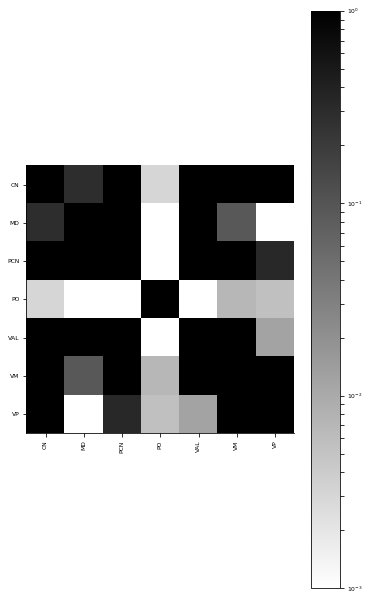

In [14]:
plt.imshow(p_r2, vmin = 0.001, vmax = 1, cmap = 'gray_r', norm=mcolors.LogNorm())
plt.colorbar()
plt.xticks(np.arange(len(label_names)), label_names, rotation = 90)
plt.yticks(np.arange(len(label_names)), label_names)

([<matplotlib.axis.YTick at 0x7feb7b61e0d0>,
 <a list of 7 Text yticklabel objects>)

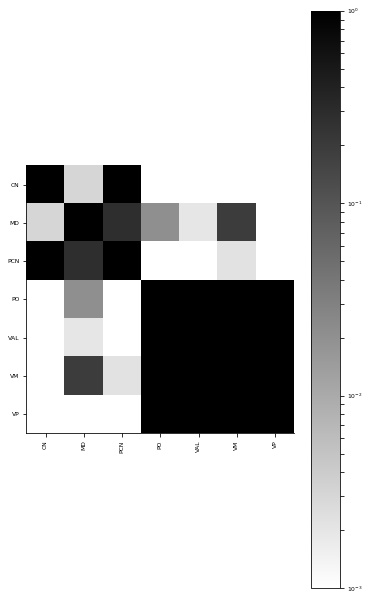

In [15]:
plt.imshow(p_fr, vmin = 0.001, vmax = 1, cmap = 'gray_r', norm=mcolors.LogNorm())
plt.colorbar()
plt.xticks(np.arange(len(label_names)), label_names, rotation = 90)
plt.yticks(np.arange(len(label_names)), label_names)

Text(0.5,1,'pairwise FR comparison')

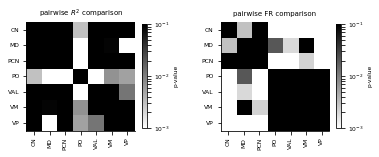

In [16]:
f,_ = plt.subplots(1,2, figsize = (5.8,2))
f.subplots_adjust(wspace = 0.5)

plt.subplot(1,2,1)
plt.imshow(p_r2, vmin = 0.001, vmax = 0.1, cmap = 'gray_r', norm=mcolors.LogNorm())
plt.colorbar(label = 'p-value', fraction = 0.04)
plt.xticks(np.arange(len(label_names)), label_names, rotation = 90)
plt.yticks(np.arange(len(label_names)), label_names)
plt.title(r'pairwise $R^2$ comparison')

plt.subplot(1,2,2)
plt.imshow(p_fr, vmin = 0.001, vmax = 0.1, cmap = 'gray_r', norm=mcolors.LogNorm())
plt.colorbar(label = 'p-value', fraction = 0.04)
plt.xticks(np.arange(len(label_names)), label_names, rotation = 90)
plt.yticks(np.arange(len(label_names)), label_names)
plt.title('pairwise FR comparison')

#plt.savefig('../figs/supplementary_figs/Thalamus_pairwise_stats_graded.pdf', dpi=300, bbox_inches='tight')

Text(0.5,1,'pairwise FR comparison')

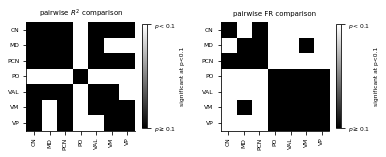

In [17]:
f,_ = plt.subplots(1,2, figsize = (5.8,2))
f.subplots_adjust(wspace = 0.5)

plt.subplot(1,2,1)
plt.imshow(p_r2<0.1, vmin = 0, vmax = 1, cmap = 'gray',)
cbar = plt.colorbar(label = 'significant at p<0.1', fraction = 0.04, ticks = [0,1])
cbar.ax.set_yticklabels([r'$p\geq0.1$', r'$p<0.1$'])
plt.xticks(np.arange(len(label_names)), label_names, rotation = 90)
plt.yticks(np.arange(len(label_names)), label_names)
plt.title(r'pairwise $R^2$ comparison')

plt.subplot(1,2,2)
plt.imshow(p_fr<0.1, vmin = 0, vmax = 1, cmap = 'gray')
cbar = plt.colorbar(label = 'significant at p<0.1', fraction = 0.04, ticks = [0,1])
cbar.ax.set_yticklabels([r'$p\geq0.1$', r'$p<0.1$'])
plt.xticks(np.arange(len(label_names)), label_names, rotation = 90)
plt.yticks(np.arange(len(label_names)), label_names)
plt.title('pairwise FR comparison')

#plt.savefig('../figs/supplementary_figs/Thalamus_pairwise_stats_discrete.pdf', dpi=300, bbox_inches='tight')